# MSA and Allele Frequency to Predict the Significance of a Variant

### Libraries & Retrieve 'msa' and 'gnomad' data 

In [311]:
import pandas as pd
import pymysql
from Bio import SeqIO
import re
from tqdm import tqdm
with open('../config.yml') as f:
    config = yaml.load(f)

project_dir = config['PROJECT']
project_db_dir = config['DATABASE']

con = pymysql.connect(host=config['MYSQL_HOST'], user=config['MYSQL_USER'], passwd=config['MYSQL_PASSWD'], 
                      db=config['MYSQL_DB'])
cur = con.cursor()

# Amino acid table
amino_acid_df = pd.DataFrame({
    "alt" : ['Ala', 'Arg', 'Asn', 'Asp', 'Asx', 'Cys', 'Glu', 'Gln', 'Glx', 'Gly', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val'],
    "singleAlt" : ['A', 'R', 'N', 'D', 'B', 'C', 'E', 'Q', 'Z', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
})
aminoacid_to_single_letter = {
    'Ala': 'A','Arg': 'R','Asn': 'N','Asp': 'D','Asx': 'B',
    'Cys': 'C','Glu': 'E','Gln': 'Q','Glx': 'Z','Gly': 'G','His': 'H',
    'Ile': 'I','Leu': 'L','Lys': 'K','Met': 'M','Phe': 'F','Pro': 'P',
    'Ser': 'S','Thr': 'T','Trp': 'W','Tyr': 'Y','Val': 'V',
}

# Retrieve gnomAD table
gnomad_data = pd.read_sql("SELECT canonical_transcript, variation, rs_number, position, " +
                          "ROUND(allele_count/allele_number,4) AS freq FROM gnomad " + 
                          "WHERE ROUND(allele_count/allele_number,4) > 0.0000 AND position != 0", con)

gnomad_data["variation"] = gnomad_data["variation"].str.split('p.', expand=True)[1]
gnomad_data["ref"] = gnomad_data["variation"].str.extract('([A-Z][a-z][a-z]*)', expand=True)
gnomad_data["alt"] = gnomad_data["variation"].str.extract('([A-Z][a-z][a-z]$)', expand=True)
for from_str, to_str in tqdm(aminoacid_to_single_letter.items()):
    gnomad_data.loc[:, 'alt'] = gnomad_data['alt'].apply(lambda x: str(x).replace(from_str, to_str))
    gnomad_data.loc[:, 'ref'] = gnomad_data['ref'].apply(lambda x: str(x).replace(from_str, to_str))

gnomad_by_gene_position = gnomad_data.groupby(['canonical_transcript', 'position'])['alt'].apply(set)
gnomad_by_gene_position_with_freq = gnomad_data.groupby(['canonical_transcript', 'position', 'alt'])['freq'].agg('last')
gnomad_by_gene_position_with_rsNumber = gnomad_data.groupby(['canonical_transcript', 'position', 'alt'])['rs_number'].agg('last')


# Retrieve msa table
msa_data = pd.read_sql("SELECT convart_gene_to_db.db_id as canonical_transcript, convart_gene_to_db.convart_gene_id, " +
                       "msa_gene.msa_id, msa.fasta FROM msa " +
                      "INNER JOIN msa_gene ON msa_gene.msa_id=msa.id AND " +
                       "msa_gene.msa_id=msa.id " +
                       "INNER JOIN convart_gene_to_db ON msa_gene.convart_gene_id=convart_gene_to_db.convart_gene_id " + 
                       "AND convart_gene_to_db.db='ENST' " +
                       "INNER JOIN convart_gene ON convart_gene.id=msa_gene.convart_gene_id " +
                       "WHERE alignment_method='clustalw' GROUP BY msa.id ", con)

# Retrieve species-specific id identifiers table
db_id_and_species = pd.read_sql("SELECT convart_gene_to_db.db_id, convart_gene.species_id FROM convart_gene_to_db " + 
                                "INNER JOIN convart_gene ON convart_gene_to_db.convart_gene_id=convart_gene.id", 
                                con)






  0%|          | 0/22 [00:00<?, ?it/s]




  5%|▍         | 1/22 [00:01<00:29,  1.39s/it]




  9%|▉         | 2/22 [00:02<00:25,  1.28s/it]




 14%|█▎        | 3/22 [00:03<00:23,  1.21s/it]




 18%|█▊        | 4/22 [00:04<00:20,  1.16s/it]




 23%|██▎       | 5/22 [00:05<00:19,  1.13s/it]




 27%|██▋       | 6/22 [00:06<00:17,  1.11s/it]




 32%|███▏      | 7/22 [00:07<00:16,  1.11s/it]




 36%|███▋      | 8/22 [00:08<00:15,  1.12s/it]




 41%|████      | 9/22 [00:10<00:14,  1.13s/it]




 45%|████▌     | 10/22 [00:11<00:13,  1.15s/it]




 50%|█████     | 11/22 [00:12<00:12,  1.17s/it]




 55%|█████▍    | 12/22 [00:13<00:11,  1.20s/it]




 59%|█████▉    | 13/22 [00:15<00:11,  1.22s/it]




 64%|██████▎   | 14/22 [00:16<00:09,  1.25s/it]




 68%|██████▊   | 15/22 [00:17<00:08,  1.26s/it]




 73%|███████▎  | 16/22 [00:18<00:07,  1.28s/it]




 77%|███████▋  | 17/22 [00:20<00:06,  1.30s/it]




 82%|████████▏ | 18/22 [00:21<00:05,  1.32s/it]




 86%|████████▋ | 19/22 [0

###  Create a data frame by parsing the msa and combine with species names

In [312]:
msa_list = []

for index, row in tqdm(msa_data.iterrows()):
    canonical_transcript = row["canonical_transcript"]
    msa_id = row["msa_id"]
    msa = row["fasta"]
    
    with open("/opt/current_project/tmp/tmp_furkan/" + canonical_transcript +".fasta", "w") as tmp_msa:
        tmp_msa.write(msa)
        tmp_msa.close()
        
    for seq in SeqIO.parse("/opt/current_project/tmp/tmp_furkan/" + canonical_transcript +".fasta", "fasta"):
        d = {}
        transcript_id = seq.id.split(".")[0]
        fasta = seq.seq
        d["msa_id"] = msa_id
        d["db_id"] = transcript_id
        d["fasta"] = str(fasta)
        
        msa_list.append(d)
        
msa_raw_df = pd.DataFrame(msa_list)

msa_df = pd.merge(msa_raw_df, db_id_and_species, on="db_id", how="inner").drop_duplicates()
msa_df_human = msa_df[msa_df["species_id"] == "Homo sapiens"]
msa_df = msa_df[(msa_df["species_id"] == "Pan troglodytes") | (msa_df["species_id"] == "Macaca mulatta") | 
                (msa_df["species_id"] == "Rattus norvegicus") | (msa_df["species_id"] == "Mus musculus")]






0it [00:00, ?it/s]




4it [00:00, 39.89it/s]




216it [00:00, 56.53it/s]




437it [00:00, 79.89it/s]




655it [00:00, 112.35it/s]




800it [00:00, 155.33it/s]




1017it [00:00, 215.29it/s]




1247it [00:00, 295.65it/s]




1465it [00:00, 399.07it/s]




1673it [00:00, 526.66it/s]




1888it [00:01, 680.79it/s]




2104it [00:01, 856.50it/s]




2311it [00:01, 1013.20it/s]




2532it [00:01, 1209.47it/s]




2741it [00:01, 1383.97it/s]




2947it [00:01, 1534.08it/s]




3172it [00:01, 1695.04it/s]




3390it [00:01, 1814.14it/s]




3610it [00:01, 1912.94it/s]




3835it [00:01, 2002.56it/s]




4072it [00:02, 2098.18it/s]




4296it [00:02, 2134.54it/s]




4529it [00:02, 2189.43it/s]




4756it [00:02, 2179.33it/s]




4979it [00:02, 2081.55it/s]




5192it [00:02, 2021.66it/s]




5419it [00:02, 2090.02it/s]




5646it [00:02, 2130.53it/s]




5882it [00:02, 2194.29it/s]




6114it [00:02, 2228.70it/s]




6339it [00:03, 2146.09it/s]




6570it [00:03, 2191.04it/s]




6

### The place where we take action

In [313]:
all_interested_positions = []
for index, row in tqdm(msa_df_human.iterrows()):
    human_msa_id = row["msa_id"]
    human_transcript_id = row["db_id"].split(".")[0]
    if human_transcript_id not in gnomad_by_gene_position.index:
        continue
    human_seq = row["fasta"]
    
    pos_with_dash = 0
    pos_without_dash = 0
    interested_position = []
    msa_query = msa_df["msa_id"] == human_msa_id
    
    list_of_species = list(msa_df[msa_query]["species_id"].drop_duplicates())
    list_of_position = gnomad_by_gene_position.loc[human_transcript_id].index.tolist()
    
    if len(list_of_species) != 4:
        continue
    for current_aminoacid in human_seq:
        pos_with_dash += 1
        if current_aminoacid == "-":
            continue;
        
        pos_without_dash += 1
        
        if pos_without_dash not in list_of_position:
            continue  
        aligned_aminoacids = list(set(msa_df[msa_query].apply(lambda x: x['fasta'][pos_with_dash-1], axis=1).tolist()))

        if '-' in aligned_aminoacids or len(aligned_aminoacids) != 1 or aligned_aminoacids[0] == current_aminoacid:
            continue

        if aligned_aminoacids[0] not in gnomad_by_gene_position.loc[human_transcript_id].loc[pos_without_dash]:
            continue
        
        miniDict = {}
        miniDict["msa_id"] = human_msa_id
        miniDict["human_transcript_id"] = human_transcript_id
        miniDict["human_position"] = pos_without_dash
        miniDict["human_from_to"] = current_aminoacid + '->' + aligned_aminoacids[0]
        miniDict["freq"]=gnomad_by_gene_position_with_freq.loc[(human_transcript_id, pos_without_dash, aligned_aminoacids[0])]
        miniDict["rsNumber"]=gnomad_by_gene_position_with_rsNumber.loc[(human_transcript_id, pos_without_dash, aligned_aminoacids[0])]
        interested_position.append(miniDict)
    
    all_interested_positions += interested_position
    






0it [00:00, ?it/s]




1it [00:00,  8.12it/s]




7it [00:00, 10.97it/s]




16it [00:00, 14.59it/s]




20it [00:00, 14.68it/s]




27it [00:00, 18.55it/s]




34it [00:00, 22.47it/s]




41it [00:01, 27.98it/s]




55it [00:01, 36.47it/s]




62it [00:01, 41.97it/s]




69it [00:01, 42.48it/s]




80it [00:01, 50.75it/s]




88it [00:01, 54.30it/s]




95it [00:01, 55.20it/s]




102it [00:01, 54.35it/s]




109it [00:02, 56.52it/s]




119it [00:02, 64.80it/s]




127it [00:02, 49.95it/s]




134it [00:02, 49.65it/s]




140it [00:02, 31.51it/s]




157it [00:03, 40.41it/s]




171it [00:03, 51.34it/s]




180it [00:03, 51.83it/s]




188it [00:03, 52.77it/s]




197it [00:03, 60.14it/s]




205it [00:03, 61.74it/s]




215it [00:03, 61.50it/s]




225it [00:03, 69.39it/s]




233it [00:04, 61.82it/s]




249it [00:04, 74.75it/s]




259it [00:04, 50.21it/s]




267it [00:04, 42.66it/s]




274it [00:04, 42.78it/s]




283it [00:05, 49.85it/s]




290it [00:05, 48.90it/s]




2

3087it [00:57, 38.00it/s]




3092it [00:57, 40.88it/s]




3100it [00:58, 46.16it/s]




3106it [00:58, 42.13it/s]




3117it [00:58, 51.39it/s]




3124it [00:58, 53.03it/s]




3131it [00:58, 36.31it/s]




3145it [00:58, 45.95it/s]




3153it [00:59, 34.57it/s]




3162it [00:59, 38.26it/s]




3171it [00:59, 46.20it/s]




3178it [00:59, 48.87it/s]




3185it [00:59, 38.77it/s]




3201it [01:00, 47.69it/s]




3208it [01:00, 35.36it/s]




3218it [01:00, 43.82it/s]




3226it [01:00, 49.54it/s]




3233it [01:00, 48.13it/s]




3242it [01:00, 53.52it/s]




3251it [01:01, 56.24it/s]




3258it [01:01, 55.98it/s]




3265it [01:01, 35.93it/s]




3271it [01:01, 39.74it/s]




3277it [01:01, 37.90it/s]




3289it [01:01, 47.08it/s]




3302it [01:02, 58.21it/s]




3311it [01:02, 50.79it/s]




3321it [01:02, 58.22it/s]




3342it [01:02, 72.40it/s]




3353it [01:02, 75.11it/s]




3363it [01:02, 57.44it/s]




3371it [01:03, 56.84it/s]




3379it [01:03, 60.58it/s]




3387it [01

5995it [01:52, 58.45it/s]




6002it [01:53, 56.43it/s]




6009it [01:53, 39.39it/s]




6015it [01:53, 39.02it/s]




6024it [01:53, 46.27it/s]




6030it [01:53, 36.37it/s]




6035it [01:54, 32.42it/s]




6040it [01:54, 36.24it/s]




6045it [01:54, 32.28it/s]




6050it [01:54, 35.97it/s]




6057it [01:54, 41.60it/s]




6069it [01:54, 50.93it/s]




6076it [01:54, 50.29it/s]




6083it [01:54, 54.21it/s]




6091it [01:55, 54.30it/s]




6101it [01:55, 59.38it/s]




6108it [01:55, 59.77it/s]




6123it [01:55, 71.53it/s]




6133it [01:55, 77.32it/s]




6142it [01:55, 74.92it/s]




6151it [01:55, 58.91it/s]




6159it [01:55, 59.72it/s]




6166it [01:56, 40.93it/s]




6173it [01:56, 46.73it/s]




6179it [01:56, 44.50it/s]




6185it [01:56, 45.87it/s]




6191it [01:56, 43.43it/s]




6201it [01:56, 51.80it/s]




6211it [01:57, 57.90it/s]




6227it [01:57, 71.51it/s]




6237it [01:57, 44.52it/s]




6245it [01:57, 47.75it/s]




6252it [01:57, 46.71it/s]




6262it [01

8760it [02:52, 48.70it/s]




8766it [02:52, 48.71it/s]




8772it [02:52, 50.60it/s]




8778it [02:52, 47.69it/s]




8784it [02:52, 42.16it/s]




8789it [02:52, 42.78it/s]




8794it [02:52, 34.42it/s]




8800it [02:53, 39.07it/s]




8814it [02:53, 47.76it/s]




8821it [02:53, 48.54it/s]




8835it [02:53, 58.69it/s]




8845it [02:53, 65.26it/s]




8853it [02:53, 61.43it/s]




8863it [02:53, 62.09it/s]




8878it [02:53, 74.16it/s]




8887it [02:54, 71.50it/s]




8896it [02:54, 64.55it/s]




8904it [02:54, 63.08it/s]




8917it [02:54, 72.63it/s]




8926it [02:55, 34.88it/s]




8933it [02:55, 37.68it/s]




8939it [02:55, 36.05it/s]




8945it [02:55, 32.83it/s]




8950it [02:55, 34.67it/s]




8958it [02:55, 40.45it/s]




8969it [02:56, 48.34it/s]




8978it [02:56, 49.02it/s]




8984it [02:56, 50.16it/s]




8993it [02:56, 57.63it/s]




9000it [02:56, 56.91it/s]




9007it [02:56, 49.10it/s]




9013it [02:56, 49.21it/s]




9020it [02:56, 50.18it/s]




9026it [02

11666it [03:47, 71.00it/s]




11674it [03:48, 41.29it/s]




11680it [03:48, 44.24it/s]




11687it [03:48, 48.38it/s]




11696it [03:48, 54.54it/s]




11704it [03:48, 60.12it/s]




11711it [03:48, 58.64it/s]




11721it [03:48, 66.70it/s]




11729it [03:49, 66.60it/s]




11743it [03:49, 76.64it/s]




11752it [03:49, 65.78it/s]




11760it [03:49, 44.99it/s]




11777it [03:49, 54.57it/s]




11785it [03:49, 57.22it/s]




11793it [03:50, 39.91it/s]




11799it [03:50, 42.08it/s]




11807it [03:50, 47.82it/s]




11813it [03:50, 45.70it/s]




11819it [03:50, 46.44it/s]




11825it [03:51, 40.44it/s]




11831it [03:51, 44.77it/s]




11837it [03:51, 42.75it/s]




11845it [03:51, 37.64it/s]




11850it [03:51, 33.45it/s]




11854it [03:51, 34.74it/s]




11864it [03:51, 43.18it/s]




11872it [03:52, 43.93it/s]




11884it [03:52, 52.80it/s]




11891it [03:52, 53.62it/s]




11898it [03:52, 43.89it/s]




11906it [03:52, 47.21it/s]




11912it [03:52, 49.72it/s]




11918it 

14549it [04:40, 38.43it/s]




14555it [04:40, 35.97it/s]




14562it [04:41, 32.07it/s]




14567it [04:41, 33.67it/s]




14573it [04:41, 36.57it/s]




14578it [04:41, 33.55it/s]




14589it [04:41, 42.29it/s]




14595it [04:41, 40.98it/s]




14601it [04:41, 39.12it/s]




14606it [04:42, 41.29it/s]




14615it [04:42, 48.45it/s]




14627it [04:42, 57.92it/s]




14635it [04:42, 44.87it/s]




14641it [04:42, 42.16it/s]




14647it [04:42, 45.36it/s]




14653it [04:42, 45.21it/s]




14660it [04:43, 49.43it/s]




14671it [04:43, 50.62it/s]




14681it [04:43, 55.47it/s]




14687it [04:43, 43.49it/s]




14693it [04:43, 44.75it/s]




14702it [04:43, 52.69it/s]




14709it [04:43, 55.90it/s]




14716it [04:44, 53.00it/s]




14734it [04:44, 64.16it/s]




14742it [04:44, 48.81it/s]




14749it [04:44, 37.64it/s]




14762it [04:44, 47.01it/s]




14770it [04:45, 43.40it/s]




14777it [04:45, 39.16it/s]




14783it [04:45, 41.04it/s]




14789it [04:45, 39.47it/s]




14797it 

17301it [05:37, 52.35it/s]




17307it [05:37, 47.84it/s]




17324it [05:37, 59.66it/s]




17332it [05:37, 64.46it/s]




17340it [05:37, 65.78it/s]




17348it [05:38, 25.87it/s]




17354it [05:38, 30.11it/s]




17360it [05:38, 28.68it/s]




17365it [05:38, 31.51it/s]




17371it [05:38, 34.48it/s]




17376it [05:39, 36.91it/s]




17387it [05:39, 43.92it/s]




17398it [05:39, 53.45it/s]




17406it [05:39, 53.30it/s]




17414it [05:39, 30.49it/s]




17423it [05:40, 37.51it/s]




17436it [05:40, 45.21it/s]




17449it [05:40, 54.44it/s]




17458it [05:40, 57.19it/s]




17467it [05:40, 64.03it/s]




17475it [05:40, 62.71it/s]




17483it [05:40, 61.09it/s]




17490it [05:41, 47.50it/s]




17496it [05:41, 35.77it/s]




17504it [05:41, 42.24it/s]




17517it [05:41, 51.76it/s]




17527it [05:41, 56.10it/s]




17535it [05:41, 59.03it/s]




17545it [05:41, 64.77it/s]




17553it [05:42, 39.15it/s]




17559it [05:42, 37.83it/s]




17565it [05:42, 38.52it/s]




17571it 

20245it [06:34, 48.13it/s]




20253it [06:34, 51.38it/s]




20262it [06:34, 56.99it/s]




20269it [06:35, 47.45it/s]




20275it [06:35, 45.73it/s]




20283it [06:35, 52.03it/s]




20289it [06:35, 45.01it/s]




20298it [06:35, 50.48it/s]




20304it [06:35, 50.61it/s]




20321it [06:35, 63.65it/s]




20330it [06:35, 58.71it/s]




20338it [06:36, 56.77it/s]




20352it [06:36, 66.70it/s]




20361it [06:36, 66.64it/s]




20369it [06:36, 57.48it/s]




20377it [06:36, 58.06it/s]




20385it [06:36, 57.65it/s]




20392it [06:37, 49.34it/s]




20399it [06:37, 50.84it/s]




20409it [06:37, 48.94it/s]




20415it [06:37, 50.55it/s]




20421it [06:37, 48.61it/s]




20428it [06:37, 50.69it/s]




20434it [06:37, 39.87it/s]




20441it [06:38, 44.24it/s]




20446it [06:38, 43.53it/s]




20453it [06:38, 45.85it/s]




20460it [06:38, 35.27it/s]




20469it [06:38, 42.09it/s]




20476it [06:38, 43.92it/s]




20482it [06:39, 44.83it/s]




20492it [06:39, 45.34it/s]




20505it 

22963it [07:32, 73.50it/s]




22975it [07:32, 83.04it/s]




22985it [07:32, 68.81it/s]




22998it [07:32, 79.74it/s]




23008it [07:33, 79.70it/s]




23018it [07:33, 75.78it/s]




23027it [07:33, 67.57it/s]




23035it [07:33, 63.46it/s]




23042it [07:33, 47.93it/s]




23048it [07:33, 46.87it/s]




23059it [07:33, 56.61it/s]




23067it [07:34, 41.36it/s]




23078it [07:34, 43.41it/s]




23084it [07:34, 41.19it/s]




23089it [07:34, 35.21it/s]




23094it [07:35, 32.21it/s]




23098it [07:35, 25.09it/s]




23108it [07:35, 32.24it/s]




23114it [07:35, 34.84it/s]




23119it [07:35, 38.08it/s]




23124it [07:35, 37.27it/s]




23129it [07:35, 39.96it/s]




23148it [07:36, 51.91it/s]




23157it [07:36, 48.98it/s]




23172it [07:36, 59.99it/s]




23181it [07:36, 61.03it/s]




23192it [07:36, 67.87it/s]




23201it [07:36, 69.99it/s]




23210it [07:36, 57.50it/s]




23217it [07:37, 48.74it/s]




23223it [07:37, 45.48it/s]




23232it [07:37, 47.80it/s]




23238it 

25886it [08:29, 53.47it/s]




25893it [08:29, 42.20it/s]




25899it [08:29, 41.50it/s]




25905it [08:29, 36.65it/s]




25910it [08:29, 35.41it/s]




25915it [08:29, 32.86it/s]




25919it [08:30, 33.22it/s]




25925it [08:30, 34.85it/s]




25934it [08:30, 41.25it/s]




25947it [08:30, 50.75it/s]




25954it [08:30, 53.43it/s]




25968it [08:30, 63.58it/s]




25976it [08:30, 54.31it/s]




25983it [08:31, 41.66it/s]




25989it [08:31, 33.38it/s]




25999it [08:31, 39.90it/s]




26005it [08:31, 41.95it/s]




26016it [08:31, 46.39it/s]




26022it [08:32, 47.51it/s]




26029it [08:32, 50.79it/s]




26038it [08:32, 58.18it/s]




26047it [08:32, 63.88it/s]




26055it [08:32, 58.41it/s]




26062it [08:32, 53.81it/s]




26068it [08:32, 47.26it/s]




26075it [08:32, 47.84it/s]




26081it [08:33, 47.35it/s]




26087it [08:33, 47.56it/s]




26092it [08:33, 32.10it/s]




26100it [08:33, 37.41it/s]




26105it [08:33, 36.62it/s]




26110it [08:33, 32.85it/s]




26116it 

28506it [09:25, 32.39it/s]




28510it [09:25, 33.30it/s]




28514it [09:25, 24.16it/s]




28520it [09:25, 27.53it/s]




28524it [09:26, 26.91it/s]




28529it [09:26, 31.13it/s]




28537it [09:26, 34.86it/s]




28541it [09:26, 29.59it/s]




28549it [09:26, 35.58it/s]




28557it [09:26, 41.04it/s]




28564it [09:26, 46.75it/s]




28570it [09:27, 45.28it/s]




28576it [09:27, 40.74it/s]




28583it [09:27, 45.53it/s]




28589it [09:27, 46.13it/s]




28595it [09:27, 48.80it/s]




28601it [09:27, 42.11it/s]




28606it [09:27, 41.96it/s]




28613it [09:27, 46.03it/s]




28621it [09:28, 52.70it/s]




28630it [09:28, 59.53it/s]




28637it [09:28, 39.92it/s]




28650it [09:28, 47.17it/s]




28658it [09:28, 50.75it/s]




28665it [09:28, 46.96it/s]




28671it [09:29, 46.09it/s]




28677it [09:29, 46.82it/s]




28683it [09:29, 39.17it/s]




28688it [09:29, 38.97it/s]




28694it [09:29, 40.50it/s]




28699it [09:29, 32.81it/s]




28710it [09:30, 39.23it/s]




28715it 

31357it [10:21, 57.73it/s]




31365it [10:21, 60.00it/s]




31373it [10:21, 44.49it/s]




31379it [10:22, 46.98it/s]




31390it [10:22, 52.57it/s]




31401it [10:22, 61.82it/s]




31409it [10:22, 65.70it/s]




31417it [10:22, 48.58it/s]




31424it [10:22, 47.27it/s]




31433it [10:23, 48.36it/s]




31444it [10:23, 57.69it/s]




31452it [10:23, 52.86it/s]




31459it [10:23, 51.27it/s]




31467it [10:23, 54.61it/s]




31473it [10:23, 53.48it/s]




31480it [10:23, 57.03it/s]




31487it [10:23, 47.20it/s]




31494it [10:24, 49.20it/s]




31503it [10:24, 52.49it/s]




31509it [10:24, 48.93it/s]




31516it [10:24, 52.36it/s]




31530it [10:24, 63.48it/s]




31538it [10:25, 20.83it/s]




31544it [10:25, 23.89it/s]




31549it [10:25, 27.03it/s]




31558it [10:26, 33.54it/s]




31564it [10:26, 33.99it/s]




31569it [10:26, 36.01it/s]




31574it [10:26, 33.61it/s]




31581it [10:26, 34.56it/s]




31586it [10:26, 35.34it/s]




31592it [10:26, 39.69it/s]




31599it 

34088it [11:20, 38.65it/s]




34097it [11:20, 45.56it/s]




34104it [11:20, 41.47it/s]




34110it [11:21, 38.67it/s]




34119it [11:21, 46.48it/s]




34126it [11:21, 47.40it/s]




34138it [11:21, 50.55it/s]




34144it [11:21, 48.32it/s]




34157it [11:21, 59.42it/s]




34165it [11:21, 55.14it/s]




34172it [11:22, 55.59it/s]




34182it [11:22, 62.29it/s]




34190it [11:22, 55.68it/s]




34198it [11:22, 51.30it/s]




34204it [11:22, 46.47it/s]




34212it [11:22, 50.92it/s]




34225it [11:22, 60.66it/s]




34233it [11:23, 52.79it/s]




34250it [11:23, 65.95it/s]




34260it [11:23, 57.27it/s]




34269it [11:23, 61.48it/s]




34277it [11:23, 54.46it/s]




34285it [11:23, 55.37it/s]




34292it [11:24, 54.48it/s]




34299it [11:24, 45.36it/s]




34305it [11:24, 43.02it/s]




34311it [11:24, 44.74it/s]




34323it [11:24, 54.79it/s]




34330it [11:24, 37.87it/s]




34343it [11:25, 47.02it/s]




34353it [11:25, 55.77it/s]




34361it [11:25, 36.94it/s]




34368it 

36886it [12:16, 51.90it/s]




36899it [12:16, 56.31it/s]




36906it [12:16, 51.95it/s]




36915it [12:16, 53.46it/s]




36921it [12:17, 44.74it/s]




36927it [12:17, 46.74it/s]




36933it [12:17, 40.91it/s]




36943it [12:17, 47.90it/s]




36949it [12:17, 45.84it/s]




36955it [12:17, 48.04it/s]




36962it [12:17, 44.75it/s]




36967it [12:18, 38.17it/s]




36975it [12:18, 44.58it/s]




36981it [12:18, 38.46it/s]




36992it [12:18, 44.12it/s]




36998it [12:18, 46.66it/s]




37004it [12:18, 42.19it/s]




37011it [12:18, 46.49it/s]




37019it [12:19, 53.02it/s]




37029it [12:19, 58.29it/s]




37040it [12:19, 66.02it/s]




37048it [12:19, 55.85it/s]




37055it [12:19, 51.03it/s]




37061it [12:19, 49.61it/s]




37067it [12:19, 47.36it/s]




37073it [12:20, 34.78it/s]




37078it [12:20, 33.33it/s]




37083it [12:20, 36.81it/s]




37090it [12:20, 42.02it/s]




37097it [12:20, 47.04it/s]




37103it [12:20, 47.06it/s]




37111it [12:20, 52.15it/s]




37120it 

39823it [13:12, 26.87it/s]




39828it [13:12, 28.06it/s]




39836it [13:12, 30.77it/s]




39845it [13:13, 38.08it/s]




39851it [13:13, 40.87it/s]




39857it [13:13, 42.62it/s]




39865it [13:13, 44.47it/s]




39871it [13:13, 45.78it/s]




39881it [13:13, 51.35it/s]




39888it [13:13, 51.14it/s]




39895it [13:13, 52.21it/s]




39901it [13:14, 44.17it/s]




39916it [13:14, 55.12it/s]




39924it [13:14, 57.63it/s]




39932it [13:14, 55.48it/s]




39939it [13:14, 53.80it/s]




39946it [13:14, 51.54it/s]




39955it [13:14, 57.48it/s]




39963it [13:15, 62.77it/s]




39973it [13:15, 65.68it/s]




39984it [13:15, 67.52it/s]




39992it [13:15, 67.38it/s]




40010it [13:15, 79.02it/s]




40019it [13:15, 60.16it/s]




40030it [13:15, 65.83it/s]




40038it [13:16, 49.97it/s]




40049it [13:16, 56.19it/s]




40056it [13:16, 53.47it/s]




40063it [13:16, 53.67it/s]




40069it [13:16, 54.10it/s]




40075it [13:16, 51.30it/s]




40081it [13:17, 43.49it/s]




40089it 

42623it [14:07, 42.04it/s]




42631it [14:07, 46.44it/s]




42638it [14:07, 50.66it/s]




42649it [14:07, 57.83it/s]




42656it [14:07, 57.88it/s]




42663it [14:08, 37.30it/s]




42669it [14:08, 34.66it/s]




42675it [14:08, 38.34it/s]




42680it [14:08, 38.85it/s]




42685it [14:08, 40.66it/s]




42690it [14:08, 40.19it/s]




42699it [14:08, 46.22it/s]




42706it [14:09, 47.35it/s]




42714it [14:09, 51.65it/s]




42720it [14:09, 48.01it/s]




42726it [14:09, 33.97it/s]




42737it [14:09, 42.55it/s]




42746it [14:09, 48.05it/s]




42753it [14:10, 44.48it/s]




42760it [14:10, 48.80it/s]




42766it [14:10, 41.40it/s]




42773it [14:10, 41.06it/s]




42778it [14:10, 33.76it/s]




42786it [14:10, 39.66it/s]




42791it [14:11, 37.63it/s]




42797it [14:11, 34.81it/s]




42805it [14:11, 40.56it/s]




42810it [14:11, 37.95it/s]




42815it [14:11, 34.65it/s]




42819it [14:11, 27.73it/s]




42823it [14:12, 26.97it/s]




42827it [14:12, 24.81it/s]




42835it 

45447it [15:03, 76.30it/s]




45456it [15:03, 50.60it/s]




45463it [15:03, 40.31it/s]




45469it [15:03, 35.24it/s]




45474it [15:03, 37.77it/s]




45479it [15:04, 29.27it/s]




45483it [15:04, 26.37it/s]




45487it [15:04, 27.25it/s]




45497it [15:04, 32.45it/s]




45513it [15:04, 41.77it/s]




45524it [15:05, 42.26it/s]




45530it [15:05, 41.76it/s]




45536it [15:05, 42.32it/s]




45542it [15:05, 43.94it/s]




45547it [15:05, 34.02it/s]




45554it [15:05, 38.06it/s]




45564it [15:06, 42.80it/s]




45569it [15:06, 27.42it/s]




45579it [15:06, 31.59it/s]




45584it [15:06, 31.77it/s]




45588it [15:06, 31.35it/s]




45592it [15:07, 28.98it/s]




45602it [15:07, 36.46it/s]




45609it [15:07, 41.58it/s]




45615it [15:07, 40.90it/s]




45620it [15:07, 41.21it/s]




45627it [15:07, 46.60it/s]




45633it [15:07, 47.26it/s]




45639it [15:08, 30.26it/s]




45644it [15:08, 24.86it/s]




45652it [15:08, 30.80it/s]




45663it [15:08, 37.79it/s]




45672it 

48230it [15:59, 41.52it/s]




48246it [15:59, 53.10it/s]




48254it [15:59, 57.27it/s]




48266it [15:59, 66.51it/s]




48276it [15:59, 71.38it/s]




48285it [16:00, 25.29it/s]




48292it [16:01, 27.58it/s]




48299it [16:01, 30.12it/s]




48305it [16:01, 35.05it/s]




48311it [16:01, 37.53it/s]




48317it [16:01, 42.20it/s]




48324it [16:01, 44.90it/s]




48330it [16:01, 45.36it/s]




48336it [16:01, 46.20it/s]




48342it [16:02, 42.29it/s]




48347it [16:02, 38.08it/s]




48356it [16:02, 45.87it/s]




48362it [16:02, 44.65it/s]




48368it [16:02, 40.82it/s]




48373it [16:02, 32.86it/s]




48385it [16:03, 40.61it/s]




48393it [16:03, 46.93it/s]




48400it [16:03, 38.55it/s]




48406it [16:03, 37.99it/s]




48411it [16:03, 27.40it/s]




48415it [16:04, 27.37it/s]




48424it [16:04, 32.73it/s]




48432it [16:04, 38.60it/s]




48437it [16:04, 39.35it/s]




48444it [16:04, 44.05it/s]




48450it [16:04, 41.30it/s]




48455it [16:04, 39.79it/s]




48460it 

51114it [16:58, 45.17it/s]




51121it [16:58, 44.48it/s]




51131it [16:58, 53.27it/s]




51138it [16:58, 51.49it/s]




51147it [16:58, 57.71it/s]




51154it [16:58, 51.04it/s]




51163it [16:59, 51.50it/s]




51169it [16:59, 49.17it/s]




51175it [16:59, 45.94it/s]




51180it [16:59, 46.55it/s]




51187it [16:59, 51.15it/s]




51193it [16:59, 47.56it/s]




51198it [17:00, 17.16it/s]




51208it [17:00, 22.65it/s]




51214it [17:00, 26.24it/s]




51220it [17:00, 31.03it/s]




51226it [17:01, 32.83it/s]




51234it [17:01, 39.50it/s]




51240it [17:01, 37.21it/s]




51248it [17:01, 42.76it/s]




51257it [17:01, 28.73it/s]




51268it [17:02, 36.38it/s]




51281it [17:02, 46.31it/s]




51289it [17:02, 38.56it/s]




51296it [17:02, 33.66it/s]




51302it [17:02, 33.47it/s]




51315it [17:03, 42.92it/s]




51323it [17:03, 45.44it/s]




51330it [17:03, 50.28it/s]




51337it [17:03, 48.86it/s]




51343it [17:03, 43.84it/s]




51355it [17:03, 53.62it/s]




51365it 

54094it [17:53, 67.53it/s]




54103it [17:54, 66.25it/s]




54111it [17:54, 65.27it/s]




54119it [17:54, 54.69it/s]




54132it [17:54, 66.06it/s]




54141it [17:54, 63.16it/s]




54149it [17:54, 62.36it/s]




54161it [17:54, 67.44it/s]




54169it [17:55, 49.87it/s]




54176it [17:55, 51.28it/s]




54184it [17:55, 54.74it/s]




54191it [17:55, 40.27it/s]




54198it [17:55, 44.06it/s]




54204it [17:55, 45.28it/s]




54216it [17:56, 48.74it/s]




54222it [17:56, 46.13it/s]




54227it [17:56, 44.58it/s]




54237it [17:56, 52.94it/s]




54244it [17:56, 45.45it/s]




54250it [17:56, 46.27it/s]




54257it [17:56, 46.81it/s]




54268it [17:57, 54.01it/s]




54275it [17:57, 53.35it/s]




54281it [17:57, 34.82it/s]




54290it [17:57, 41.52it/s]




54296it [17:58, 22.04it/s]




54303it [17:58, 27.73it/s]




54312it [17:58, 34.48it/s]




54324it [17:58, 43.69it/s]




54332it [17:58, 42.12it/s]




54340it [17:58, 48.42it/s]




54349it [17:58, 56.02it/s]




54360it 

### Finally, create a dataframe for all interested positions

In [467]:
all_interested_positions_df = pd.DataFrame(all_interested_positions)
all_interested_positions_df.head()

,freq,human_from_to,human_position,human_transcript_id,msa_id,rsNumber
0,0.6177,Q->R,63,ENST00000536471,17,rs2501432
1,0.0466,S->N,183,ENST00000247161,22,rs1059579
2,0.5620,V->A,82,ENST00000375448,34,rs11203367
3,0.1292,I->T,762,ENST00000369702,39,rs85276
4,0.0009,V->F,9,ENST00000398462,60,rs199650561


### Get Polyphen and SIFT Score for our all interested positions

In [367]:
import requests, sys
import json
vep_end_point = "https://rest.ensembl.org/vep/human/id/"

whole_vp_list = []
for index, row in tqdm(all_interested_positions_df.iterrows()):
    human_transcript_id = row["human_transcript_id"]
    rs_number = row["rsNumber"]
    human_from_to = row["human_from_to"]
    try:
        r = requests.get(vep_end_point+rs_number+"?content-type=application/json&transcript_id="+human_transcript_id)
        decoded = r.json()
        vepDict = {}
        vepDict["rsNumber"] = decoded[0]["input"]
        vepDict["biotype"] = decoded[0]["transcript_consequences"][0]["biotype"]
        vepDict["transcript_id"] = decoded[0]["transcript_consequences"][0]["transcript_id"]
        vepDict["human_from_to"] = decoded[0]["transcript_consequences"][0]["amino_acids"].replace("/","->")
        vepDict["polyphen_prediction"] = decoded[0]["transcript_consequences"][0]["polyphen_prediction"]
        vepDict["polyphen_score"] = decoded[0]["transcript_consequences"][0]["polyphen_score"]
        vepDict["sift_prediction"] = decoded[0]["transcript_consequences"][0]["sift_prediction"]
        vepDict["sift_score"] = decoded[0]["transcript_consequences"][0]["sift_score"]
        whole_vp_list.append(vepDict)
    except KeyError:
        continue
        








0it [00:00, ?it/s]






1it [00:01,  1.37s/it]






2it [00:02,  1.24s/it]






3it [00:03,  1.33s/it]






4it [00:06,  1.61s/it]






5it [00:07,  1.59s/it]






6it [00:08,  1.45s/it]






7it [00:09,  1.27s/it]






8it [00:10,  1.12s/it]






9it [00:12,  1.37s/it]






10it [00:13,  1.24s/it]






11it [00:14,  1.36s/it]






12it [00:16,  1.34s/it]






13it [00:17,  1.19s/it]






14it [00:18,  1.21s/it]






15it [00:20,  1.41s/it]






16it [00:21,  1.32s/it]






17it [00:22,  1.27s/it]






18it [00:23,  1.22s/it]






19it [00:24,  1.13s/it]






20it [00:25,  1.22s/it]






21it [00:27,  1.23s/it]






22it [00:28,  1.18s/it]






23it [00:29,  1.15s/it]






24it [00:30,  1.30s/it]






25it [00:32,  1.24s/it]






26it [00:33,  1.20s/it]






27it [00:34,  1.24s/it]






28it [00:38,  2.16s/it]






29it [00:40,  2.09s/it]






30it [00:41,  1.74s/it]






31it [00:42,  1.47s/it]






32it [00:43,  1.31s/it]






33it [00:45,  1.4

316it [09:19,  2.00s/it]






317it [09:20,  1.75s/it]






318it [09:22,  1.90s/it]






319it [09:24,  1.90s/it]






320it [09:25,  1.62s/it]






321it [09:27,  1.86s/it]






322it [09:29,  1.62s/it]






323it [09:31,  1.91s/it]






324it [09:32,  1.68s/it]






325it [09:38,  2.84s/it]






326it [09:39,  2.29s/it]






327it [09:43,  2.99s/it]






328it [09:45,  2.50s/it]






329it [09:46,  2.06s/it]






330it [09:47,  1.84s/it]






331it [09:50,  2.06s/it]






332it [09:52,  2.08s/it]






333it [09:53,  1.72s/it]






334it [09:54,  1.53s/it]






335it [09:55,  1.36s/it]






336it [09:56,  1.18s/it]






337it [09:57,  1.13s/it]






338it [09:57,  1.06s/it]






339it [09:59,  1.24s/it]






340it [10:00,  1.15s/it]






341it [10:01,  1.22s/it]






342it [10:03,  1.41s/it]






343it [10:05,  1.49s/it]






344it [10:06,  1.41s/it]






345it [10:07,  1.33s/it]






346it [10:08,  1.26s/it]






347it [10:10,  1.22s/it]






348it [1

630it [18:21,  1.55s/it]






631it [18:23,  1.67s/it]






632it [18:25,  1.53s/it]






633it [18:26,  1.41s/it]






634it [18:27,  1.38s/it]






635it [18:28,  1.41s/it]






636it [18:31,  1.80s/it]






637it [18:32,  1.38s/it]






638it [18:33,  1.32s/it]






639it [18:35,  1.52s/it]






640it [18:37,  1.69s/it]






641it [18:38,  1.53s/it]






642it [18:40,  1.62s/it]






643it [18:41,  1.50s/it]






644it [18:42,  1.46s/it]






645it [18:44,  1.44s/it]






646it [18:45,  1.37s/it]






647it [18:46,  1.29s/it]






648it [18:47,  1.14s/it]






649it [18:48,  1.20s/it]






650it [18:49,  1.11s/it]






651it [18:51,  1.19s/it]






652it [18:52,  1.21s/it]






653it [18:53,  1.27s/it]






654it [18:55,  1.48s/it]






655it [18:56,  1.44s/it]






656it [18:58,  1.32s/it]






657it [18:59,  1.23s/it]






658it [19:00,  1.41s/it]






659it [19:02,  1.37s/it]






660it [19:03,  1.32s/it]






661it [19:04,  1.32s/it]






662it [1

944it [26:23,  1.40s/it]






945it [26:24,  1.40s/it]






946it [26:26,  1.46s/it]






947it [26:28,  1.89s/it]






948it [26:31,  2.03s/it]






949it [26:33,  1.99s/it]






950it [26:35,  1.98s/it]






951it [26:36,  1.74s/it]






952it [26:37,  1.46s/it]






953it [26:38,  1.44s/it]






954it [26:39,  1.31s/it]






955it [26:40,  1.28s/it]






956it [26:42,  1.30s/it]






957it [26:43,  1.26s/it]






958it [26:44,  1.39s/it]






959it [26:46,  1.53s/it]






960it [26:48,  1.57s/it]






961it [26:50,  1.84s/it]






962it [26:53,  2.13s/it]






963it [26:54,  1.86s/it]






964it [26:56,  1.77s/it]






965it [26:58,  1.95s/it]






966it [27:00,  1.79s/it]






967it [27:01,  1.60s/it]






968it [27:03,  1.81s/it]






969it [27:04,  1.61s/it]






970it [27:08,  2.29s/it]






971it [27:10,  2.26s/it]






972it [27:12,  1.96s/it]






973it [27:13,  1.74s/it]






974it [27:15,  1.83s/it]






975it [27:16,  1.65s/it]






976it [2

1253it [34:49,  1.37s/it]






1254it [34:50,  1.34s/it]






1255it [34:51,  1.27s/it]






1256it [34:53,  1.37s/it]






1257it [34:53,  1.24s/it]






1258it [34:54,  1.16s/it]






1259it [34:57,  1.48s/it]






1260it [34:58,  1.58s/it]






1261it [35:00,  1.68s/it]






1262it [35:01,  1.45s/it]






1263it [35:03,  1.54s/it]






1264it [35:04,  1.48s/it]






1265it [35:06,  1.59s/it]






1266it [35:08,  1.55s/it]






1267it [35:09,  1.47s/it]






1268it [35:11,  1.56s/it]






1269it [35:13,  1.73s/it]






1270it [35:15,  1.77s/it]






1271it [35:16,  1.77s/it]






1272it [35:17,  1.52s/it]






1273it [35:20,  1.96s/it]






1274it [35:25,  2.82s/it]






1275it [35:27,  2.51s/it]






1276it [35:30,  2.62s/it]






1277it [35:31,  2.08s/it]






1278it [35:32,  1.78s/it]






1279it [35:33,  1.59s/it]






1280it [35:35,  1.67s/it]






1281it [35:37,  1.82s/it]






1282it [35:38,  1.65s/it]






1283it [35:39,  1.53s/it]






1284it [

1561it [43:16,  1.09s/it]






1562it [43:18,  1.46s/it]






1563it [43:19,  1.35s/it]






1564it [43:21,  1.53s/it]






1565it [43:22,  1.39s/it]






1566it [43:23,  1.30s/it]






1567it [43:25,  1.28s/it]






1568it [43:32,  3.24s/it]






1569it [43:34,  2.74s/it]






1570it [43:37,  2.72s/it]






1571it [43:39,  2.48s/it]






1572it [43:40,  2.06s/it]






1573it [43:43,  2.34s/it]






1574it [43:45,  2.35s/it]






1575it [43:47,  2.18s/it]






1576it [43:48,  1.96s/it]






1577it [43:49,  1.68s/it]






1578it [43:50,  1.44s/it]






1579it [43:52,  1.52s/it]






1580it [43:54,  1.63s/it]






1581it [43:55,  1.38s/it]






1582it [43:56,  1.39s/it]






1583it [43:59,  1.74s/it]






1584it [44:01,  1.88s/it]






1585it [44:02,  1.67s/it]






1586it [44:03,  1.54s/it]






1587it [44:04,  1.35s/it]






1588it [44:06,  1.38s/it]






1589it [44:08,  1.59s/it]






1590it [44:09,  1.58s/it]






1591it [44:11,  1.69s/it]






1592it [

1869it [51:34,  2.30s/it]






1870it [51:38,  2.80s/it]






1871it [51:42,  3.11s/it]






1872it [51:45,  3.09s/it]






1873it [51:47,  2.75s/it]






1874it [51:47,  2.17s/it]






1875it [51:49,  1.93s/it]






1876it [51:50,  1.74s/it]






1877it [51:53,  2.16s/it]






1878it [51:57,  2.68s/it]






1879it [52:00,  2.74s/it]






1880it [52:02,  2.41s/it]






1881it [52:03,  2.17s/it]






1882it [52:06,  2.21s/it]






1883it [52:08,  2.24s/it]






1884it [52:09,  1.96s/it]






1885it [52:11,  1.87s/it]






1886it [52:12,  1.71s/it]






1887it [52:14,  1.89s/it]






1888it [52:17,  1.97s/it]






1889it [52:19,  2.08s/it]






1890it [52:21,  2.04s/it]






1891it [52:23,  2.04s/it]






1892it [52:25,  2.08s/it]






1893it [52:27,  2.14s/it]






1894it [52:29,  1.97s/it]






1895it [52:31,  2.11s/it]






1896it [52:34,  2.38s/it]






1897it [52:36,  2.20s/it]






1898it [52:38,  2.21s/it]






1899it [52:40,  1.89s/it]






1900it [

2177it [1:00:15,  1.74s/it]






2178it [1:00:17,  1.81s/it]






2179it [1:00:19,  1.70s/it]






2180it [1:00:20,  1.48s/it]






2181it [1:00:22,  1.66s/it]






2182it [1:00:24,  1.78s/it]






2183it [1:00:25,  1.63s/it]






2184it [1:00:27,  1.71s/it]






2185it [1:00:29,  1.66s/it]






2186it [1:00:30,  1.49s/it]






2187it [1:00:31,  1.30s/it]






2188it [1:00:32,  1.34s/it]






2189it [1:00:34,  1.62s/it]






2190it [1:00:36,  1.50s/it]






2191it [1:00:37,  1.62s/it]






2192it [1:00:38,  1.42s/it]






2193it [1:00:41,  1.78s/it]






2194it [1:00:43,  1.78s/it]






2195it [1:00:44,  1.57s/it]






2196it [1:00:46,  1.63s/it]






2197it [1:00:47,  1.51s/it]






2198it [1:00:48,  1.54s/it]






2199it [1:00:50,  1.61s/it]






2200it [1:00:52,  1.50s/it]






2201it [1:00:54,  1.66s/it]






2202it [1:00:55,  1.63s/it]






2203it [1:00:57,  1.67s/it]






2204it [1:00:58,  1.50s/it]






2205it [1:00:59,  1.29s/it]






2206it [1:01:0

2326it [1:04:36,  1.85s/it]






2327it [1:04:38,  1.83s/it]






2328it [1:04:39,  1.65s/it]






2329it [1:04:40,  1.53s/it]






2330it [1:04:42,  1.44s/it]






2331it [1:04:43,  1.37s/it]






2332it [1:04:44,  1.28s/it]






2333it [1:04:45,  1.21s/it]






2334it [1:04:46,  1.19s/it]






2335it [1:04:47,  1.16s/it]






2336it [1:04:49,  1.24s/it]






2337it [1:04:50,  1.18s/it]






2338it [1:04:51,  1.16s/it]






2339it [1:04:52,  1.08s/it]






2340it [1:04:53,  1.29s/it]






2341it [1:04:55,  1.49s/it]






2342it [1:04:57,  1.40s/it]






2343it [1:04:58,  1.31s/it]






2344it [1:04:59,  1.22s/it]






2345it [1:05:00,  1.15s/it]






2346it [1:05:01,  1.11s/it]






2347it [1:05:02,  1.19s/it]






2348it [1:05:03,  1.24s/it]






2349it [1:05:04,  1.15s/it]






2350it [1:05:06,  1.21s/it]






2351it [1:05:07,  1.36s/it]






2352it [1:05:09,  1.35s/it]






2353it [1:05:10,  1.24s/it]






2354it [1:05:10,  1.10s/it]






2355it [1:05:1

2475it [1:08:20,  1.62s/it]






2476it [1:08:23,  1.76s/it]






2477it [1:08:23,  1.47s/it]






2478it [1:08:25,  1.40s/it]






2479it [1:08:25,  1.24s/it]






2480it [1:08:28,  1.74s/it]






2481it [1:08:29,  1.54s/it]






2482it [1:08:31,  1.49s/it]






2483it [1:08:33,  1.60s/it]






2484it [1:08:34,  1.45s/it]






2485it [1:08:36,  1.59s/it]






2486it [1:08:39,  2.06s/it]






2487it [1:08:40,  1.92s/it]






2488it [1:08:42,  1.73s/it]






2489it [1:08:43,  1.75s/it]






2490it [1:08:45,  1.60s/it]






2491it [1:08:46,  1.51s/it]






2492it [1:08:48,  1.74s/it]






2493it [1:08:51,  1.95s/it]






2494it [1:08:52,  1.69s/it]






2495it [1:08:53,  1.62s/it]






2496it [1:08:54,  1.49s/it]






2497it [1:08:56,  1.41s/it]






2498it [1:08:57,  1.39s/it]






2499it [1:08:58,  1.38s/it]






2500it [1:08:59,  1.27s/it]






2501it [1:09:00,  1.16s/it]






2502it [1:09:01,  1.12s/it]






2503it [1:09:03,  1.19s/it]






2504it [1:09:0

2624it [1:12:01,  1.80s/it]






2625it [1:12:02,  1.49s/it]






2626it [1:12:05,  1.99s/it]






2627it [1:12:07,  2.05s/it]






2628it [1:12:09,  2.02s/it]






2629it [1:12:11,  1.75s/it]






2630it [1:12:13,  1.91s/it]






2631it [1:12:14,  1.80s/it]






2632it [1:12:16,  1.78s/it]






2633it [1:12:18,  1.72s/it]






2634it [1:12:20,  1.80s/it]






2635it [1:12:21,  1.76s/it]






2636it [1:12:22,  1.57s/it]






2637it [1:12:24,  1.52s/it]






2638it [1:12:25,  1.45s/it]






2639it [1:12:26,  1.35s/it]






2640it [1:12:29,  1.74s/it]






2641it [1:12:31,  1.79s/it]






2642it [1:12:33,  1.81s/it]






2643it [1:12:36,  2.19s/it]






2644it [1:12:38,  2.18s/it]






2645it [1:12:39,  1.95s/it]






2646it [1:12:41,  1.79s/it]






2647it [1:12:44,  2.26s/it]






2648it [1:12:47,  2.53s/it]






2649it [1:12:49,  2.25s/it]






2650it [1:12:50,  1.80s/it]






2651it [1:12:51,  1.57s/it]






2652it [1:12:52,  1.41s/it]






2653it [1:12:5

2773it [1:15:58,  1.96s/it]






2774it [1:15:59,  1.77s/it]






2775it [1:16:03,  2.18s/it]






2776it [1:16:04,  1.93s/it]






2777it [1:16:05,  1.59s/it]






2778it [1:16:07,  1.72s/it]






2779it [1:16:08,  1.57s/it]






2780it [1:16:10,  1.58s/it]






2781it [1:16:11,  1.39s/it]






2782it [1:16:12,  1.29s/it]






2783it [1:16:13,  1.19s/it]






2784it [1:16:15,  1.47s/it]






2785it [1:16:16,  1.34s/it]






2786it [1:16:18,  1.76s/it]






2787it [1:16:19,  1.53s/it]






2788it [1:16:21,  1.56s/it]






2789it [1:16:23,  1.66s/it]






2790it [1:16:24,  1.39s/it]






2791it [1:16:25,  1.40s/it]






2792it [1:16:27,  1.48s/it]






2793it [1:16:28,  1.41s/it]






2794it [1:16:29,  1.38s/it]






2795it [1:16:30,  1.22s/it]






2796it [1:16:32,  1.32s/it]






2797it [1:16:35,  1.75s/it]






2798it [1:16:35,  1.46s/it]






2799it [1:16:37,  1.39s/it]






2800it [1:16:38,  1.35s/it]






2801it [1:16:39,  1.30s/it]






2802it [1:16:4

2922it [1:19:31,  1.51s/it]






2923it [1:19:32,  1.31s/it]






2924it [1:19:33,  1.19s/it]






2925it [1:19:35,  1.27s/it]






2926it [1:19:36,  1.18s/it]






2927it [1:19:36,  1.08s/it]






2928it [1:19:37,  1.02s/it]






2929it [1:19:38,  1.05s/it]






2930it [1:19:39,  1.00s/it]






2931it [1:19:41,  1.18s/it]






2932it [1:19:43,  1.43s/it]






2933it [1:19:44,  1.36s/it]






2934it [1:19:46,  1.39s/it]






2935it [1:19:47,  1.42s/it]






2936it [1:19:48,  1.40s/it]






2937it [1:19:49,  1.22s/it]






2938it [1:19:50,  1.12s/it]






2939it [1:19:52,  1.36s/it]






2940it [1:19:55,  1.76s/it]






2941it [1:19:56,  1.64s/it]






2942it [1:19:59,  2.07s/it]






2943it [1:20:02,  2.25s/it]






2944it [1:20:03,  1.99s/it]






2945it [1:20:05,  1.95s/it]






2946it [1:20:06,  1.78s/it]






2947it [1:20:09,  1.89s/it]






2948it [1:20:10,  1.80s/it]






2949it [1:20:12,  1.74s/it]






2950it [1:20:12,  1.44s/it]






2951it [1:20:1

3071it [1:23:15,  1.44s/it]






3072it [1:23:17,  1.54s/it]






3073it [1:23:18,  1.51s/it]






3074it [1:23:19,  1.49s/it]






3075it [1:23:21,  1.55s/it]






3076it [1:23:22,  1.40s/it]






3077it [1:23:23,  1.28s/it]






3078it [1:23:25,  1.57s/it]






3079it [1:23:27,  1.47s/it]






3080it [1:23:28,  1.38s/it]






3081it [1:23:29,  1.32s/it]






3082it [1:23:31,  1.40s/it]






3083it [1:23:32,  1.31s/it]






3084it [1:23:33,  1.26s/it]






3085it [1:23:34,  1.18s/it]






3086it [1:23:35,  1.20s/it]






3087it [1:23:37,  1.39s/it]






3088it [1:23:39,  1.64s/it]






3089it [1:23:41,  1.60s/it]






3090it [1:23:42,  1.56s/it]






3091it [1:23:43,  1.36s/it]






3092it [1:23:44,  1.33s/it]






3093it [1:23:46,  1.52s/it]






3094it [1:23:47,  1.38s/it]






3095it [1:23:49,  1.47s/it]






3096it [1:23:51,  1.59s/it]






3097it [1:23:53,  1.63s/it]






3098it [1:23:55,  1.79s/it]






3099it [1:23:58,  2.17s/it]






3100it [1:24:0

3220it [1:27:34,  1.50s/it]






3221it [1:27:35,  1.41s/it]






3222it [1:27:36,  1.37s/it]






3223it [1:27:39,  1.65s/it]






3224it [1:27:41,  1.92s/it]






3225it [1:27:43,  1.76s/it]






3226it [1:27:44,  1.72s/it]






3227it [1:27:46,  1.69s/it]






3228it [1:27:47,  1.52s/it]






3229it [1:27:48,  1.36s/it]






3230it [1:27:49,  1.27s/it]






3231it [1:27:50,  1.28s/it]






3232it [1:27:51,  1.22s/it]






3233it [1:27:53,  1.30s/it]






3234it [1:27:54,  1.28s/it]






3235it [1:27:56,  1.44s/it]






3236it [1:27:57,  1.28s/it]






3237it [1:28:00,  1.79s/it]






3238it [1:28:03,  2.11s/it]






3239it [1:28:05,  2.02s/it]






3240it [1:28:06,  1.92s/it]






3241it [1:28:07,  1.69s/it]






3242it [1:28:08,  1.47s/it]






3243it [1:28:10,  1.47s/it]






3244it [1:28:12,  1.76s/it]






3245it [1:28:14,  1.88s/it]






3246it [1:28:16,  1.88s/it]






3247it [1:28:18,  1.84s/it]






3248it [1:28:19,  1.67s/it]






3249it [1:28:2

3369it [1:31:19,  1.15s/it]






3370it [1:31:20,  1.05s/it]






3371it [1:31:21,  1.04it/s]






3372it [1:31:22,  1.09it/s]






3373it [1:31:23,  1.13it/s]






3374it [1:31:25,  1.31s/it]






3375it [1:31:27,  1.48s/it]






3376it [1:31:29,  1.82s/it]






3377it [1:31:32,  2.08s/it]






3378it [1:31:33,  1.80s/it]






3379it [1:31:35,  1.76s/it]






3380it [1:31:37,  1.90s/it]






3381it [1:31:38,  1.59s/it]






3382it [1:31:40,  1.65s/it]






3383it [1:31:41,  1.54s/it]






3384it [1:31:43,  1.81s/it]






3385it [1:31:44,  1.58s/it]






3386it [1:31:46,  1.49s/it]






3387it [1:31:47,  1.35s/it]






3388it [1:31:48,  1.21s/it]






3389it [1:31:49,  1.14s/it]






3390it [1:31:50,  1.30s/it]






3391it [1:31:52,  1.56s/it]






3392it [1:31:54,  1.44s/it]






3393it [1:31:56,  1.61s/it]






3394it [1:31:57,  1.57s/it]






3395it [1:31:59,  1.57s/it]






3396it [1:32:00,  1.59s/it]






3397it [1:32:01,  1.45s/it]






3398it [1:32:0

3518it [1:34:52,  1.23s/it]






3519it [1:34:54,  1.24s/it]






3520it [1:34:56,  1.43s/it]






3521it [1:34:57,  1.40s/it]






3522it [1:34:58,  1.35s/it]






3523it [1:34:59,  1.26s/it]






3524it [1:35:00,  1.25s/it]






3525it [1:35:02,  1.24s/it]






3526it [1:35:04,  1.47s/it]






3527it [1:35:05,  1.31s/it]






3528it [1:35:07,  1.58s/it]






3529it [1:35:08,  1.46s/it]






3530it [1:35:09,  1.34s/it]






3531it [1:35:11,  1.54s/it]






3532it [1:35:12,  1.35s/it]






3533it [1:35:14,  1.50s/it]






3534it [1:35:15,  1.47s/it]






3535it [1:35:16,  1.31s/it]






3536it [1:35:17,  1.17s/it]






3537it [1:35:18,  1.18s/it]






3538it [1:35:19,  1.07s/it]






3539it [1:35:20,  1.05s/it]






3540it [1:35:21,  1.04s/it]






3541it [1:35:23,  1.19s/it]






3542it [1:35:24,  1.33s/it]






3543it [1:35:26,  1.35s/it]






3544it [1:35:27,  1.25s/it]






3545it [1:35:28,  1.27s/it]






3546it [1:35:29,  1.29s/it]






3547it [1:35:3

3667it [1:38:43,  1.31s/it]






3668it [1:38:44,  1.28s/it]






3669it [1:38:46,  1.42s/it]






3670it [1:38:47,  1.39s/it]






3671it [1:38:49,  1.43s/it]






3672it [1:38:50,  1.29s/it]






3673it [1:38:51,  1.30s/it]






3674it [1:38:52,  1.22s/it]






3675it [1:38:54,  1.43s/it]






3676it [1:38:55,  1.47s/it]






3677it [1:38:57,  1.38s/it]






3678it [1:38:58,  1.36s/it]






3679it [1:38:59,  1.24s/it]






3680it [1:39:00,  1.26s/it]






3681it [1:39:01,  1.22s/it]






3682it [1:39:03,  1.24s/it]






3683it [1:39:04,  1.17s/it]






3684it [1:39:05,  1.12s/it]






3685it [1:39:06,  1.22s/it]






3686it [1:39:08,  1.36s/it]






3687it [1:39:09,  1.31s/it]






3688it [1:39:10,  1.34s/it]






3689it [1:39:11,  1.28s/it]






3690it [1:39:13,  1.34s/it]






3691it [1:39:15,  1.42s/it]






3692it [1:39:15,  1.22s/it]






3693it [1:39:16,  1.20s/it]






3694it [1:39:18,  1.15s/it]






3695it [1:39:19,  1.27s/it]






3696it [1:39:2

3816it [1:42:14,  1.22s/it]






3817it [1:42:16,  1.39s/it]






3818it [1:42:17,  1.44s/it]






3819it [1:42:18,  1.34s/it]






3820it [1:42:19,  1.22s/it]






3821it [1:42:21,  1.30s/it]






3822it [1:42:22,  1.25s/it]






3823it [1:42:24,  1.65s/it]






3824it [1:42:26,  1.51s/it]






3825it [1:42:28,  1.90s/it]






3826it [1:42:30,  1.78s/it]






3827it [1:42:32,  1.76s/it]






3828it [1:42:36,  2.59s/it]






3829it [1:42:38,  2.25s/it]






3830it [1:42:39,  1.86s/it]






3831it [1:42:40,  1.68s/it]






3832it [1:42:41,  1.49s/it]






3833it [1:42:42,  1.52s/it]






3834it [1:42:44,  1.45s/it]






3835it [1:42:46,  1.59s/it]






3836it [1:42:47,  1.36s/it]






3837it [1:42:48,  1.30s/it]






3838it [1:42:48,  1.13s/it]






3839it [1:42:49,  1.01s/it]






3840it [1:42:50,  1.03it/s]






3841it [1:42:51,  1.09it/s]






3842it [1:42:52,  1.10it/s]






3843it [1:42:53,  1.12it/s]






3844it [1:42:53,  1.23it/s]






3845it [1:42:5

3965it [1:45:49,  1.29s/it]






3966it [1:45:50,  1.32s/it]






3967it [1:45:51,  1.35s/it]






3968it [1:45:53,  1.36s/it]






3969it [1:45:54,  1.21s/it]






3970it [1:45:55,  1.39s/it]






3971it [1:45:56,  1.18s/it]






3972it [1:45:57,  1.17s/it]






3973it [1:45:59,  1.33s/it]






3974it [1:46:00,  1.27s/it]






3975it [1:46:01,  1.15s/it]






3976it [1:46:02,  1.13s/it]






3977it [1:46:04,  1.29s/it]






3978it [1:46:05,  1.44s/it]






3979it [1:46:06,  1.30s/it]






3980it [1:46:07,  1.22s/it]






3981it [1:46:08,  1.14s/it]






3982it [1:46:10,  1.37s/it]






3983it [1:46:13,  1.78s/it]






3984it [1:46:14,  1.65s/it]






3985it [1:46:16,  1.49s/it]






3986it [1:46:17,  1.46s/it]






3987it [1:46:19,  1.59s/it]






3988it [1:46:20,  1.37s/it]






3989it [1:46:21,  1.45s/it]






3990it [1:46:23,  1.46s/it]






3991it [1:46:24,  1.53s/it]






3992it [1:46:26,  1.55s/it]






3993it [1:46:27,  1.46s/it]






3994it [1:46:2

4114it [1:49:14,  1.26s/it]






4115it [1:49:16,  1.35s/it]






4116it [1:49:17,  1.21s/it]






4117it [1:49:18,  1.30s/it]






4118it [1:49:20,  1.37s/it]






4119it [1:49:22,  1.57s/it]






4120it [1:49:25,  2.24s/it]






4121it [1:49:29,  2.78s/it]






4122it [1:49:34,  3.28s/it]






4123it [1:49:35,  2.60s/it]






4124it [1:49:36,  2.17s/it]






4125it [1:49:37,  1.88s/it]






4126it [1:49:38,  1.64s/it]






4127it [1:49:39,  1.48s/it]






4128it [1:49:40,  1.34s/it]






4129it [1:49:42,  1.38s/it]






4130it [1:49:43,  1.41s/it]






4131it [1:49:45,  1.44s/it]






4132it [1:49:46,  1.29s/it]






4133it [1:49:47,  1.22s/it]






4134it [1:49:48,  1.15s/it]






4135it [1:49:49,  1.20s/it]






4136it [1:49:50,  1.13s/it]






4137it [1:49:53,  1.60s/it]






4138it [1:49:54,  1.45s/it]






4139it [1:49:55,  1.44s/it]






4140it [1:49:56,  1.33s/it]






4141it [1:49:59,  1.68s/it]






4142it [1:50:00,  1.41s/it]






4143it [1:50:0

4263it [1:52:39,  1.14s/it]






4264it [1:52:40,  1.12s/it]






4265it [1:52:41,  1.05s/it]






4266it [1:52:42,  1.11s/it]






4267it [1:52:43,  1.21s/it]






4268it [1:52:45,  1.28s/it]






4269it [1:52:46,  1.41s/it]






4270it [1:52:48,  1.51s/it]






4271it [1:52:49,  1.38s/it]






4272it [1:52:50,  1.31s/it]






4273it [1:52:51,  1.21s/it]






4274it [1:52:52,  1.10s/it]






4275it [1:52:53,  1.08s/it]






4276it [1:52:54,  1.03it/s]






4277it [1:52:55,  1.12it/s]






4278it [1:52:56,  1.12it/s]






4279it [1:52:57,  1.10it/s]






4280it [1:52:58,  1.09s/it]






4281it [1:52:59,  1.01s/it]






4282it [1:53:00,  1.04s/it]






4283it [1:53:02,  1.21s/it]






4284it [1:53:03,  1.11s/it]






4285it [1:53:03,  1.03s/it]






4286it [1:53:04,  1.02it/s]






4287it [1:53:05,  1.04s/it]






4288it [1:53:07,  1.21s/it]






4289it [1:53:08,  1.11s/it]






4290it [1:53:09,  1.06s/it]






4291it [1:53:10,  1.01it/s]






4292it [1:53:1

4412it [1:55:39,  1.08s/it]






4413it [1:55:40,  1.11s/it]






4414it [1:55:41,  1.08s/it]






4415it [1:55:42,  1.07s/it]






4416it [1:55:43,  1.05s/it]






4417it [1:55:44,  1.10s/it]






4418it [1:55:45,  1.11s/it]






4419it [1:55:46,  1.04s/it]






4420it [1:55:48,  1.24s/it]






4421it [1:55:49,  1.14s/it]






4422it [1:55:50,  1.23s/it]






4423it [1:55:52,  1.27s/it]






4424it [1:55:53,  1.15s/it]






4425it [1:55:54,  1.34s/it]






4426it [1:55:56,  1.52s/it]






4427it [1:55:58,  1.69s/it]






4428it [1:56:00,  1.61s/it]






4429it [1:56:01,  1.49s/it]






4430it [1:56:02,  1.44s/it]






4431it [1:56:04,  1.39s/it]






4432it [1:56:06,  1.67s/it]






4433it [1:56:07,  1.53s/it]






4434it [1:56:09,  1.45s/it]






4435it [1:56:10,  1.41s/it]






4436it [1:56:11,  1.35s/it]






4437it [1:56:12,  1.31s/it]






4438it [1:56:13,  1.28s/it]






4439it [1:56:15,  1.31s/it]






4440it [1:56:16,  1.38s/it]






4441it [1:56:1

4561it [1:58:53,  1.51s/it]






4562it [1:58:53,  1.31s/it]






4563it [1:58:54,  1.12s/it]






4564it [1:58:55,  1.12s/it]






4565it [1:58:57,  1.25s/it]






4566it [1:58:58,  1.20s/it]






4567it [1:58:59,  1.23s/it]






4568it [1:59:00,  1.16s/it]






4569it [1:59:02,  1.26s/it]






4570it [1:59:03,  1.41s/it]






4571it [1:59:05,  1.51s/it]






4572it [1:59:06,  1.31s/it]






4573it [1:59:08,  1.61s/it]






4574it [1:59:09,  1.35s/it]






4575it [1:59:11,  1.50s/it]






4576it [1:59:13,  1.54s/it]






4577it [1:59:14,  1.63s/it]






4578it [1:59:16,  1.51s/it]






4579it [1:59:17,  1.54s/it]






4580it [1:59:18,  1.40s/it]






4581it [1:59:19,  1.33s/it]






4582it [1:59:20,  1.20s/it]






4583it [1:59:22,  1.31s/it]






4584it [1:59:23,  1.31s/it]






4585it [1:59:24,  1.26s/it]






4586it [1:59:26,  1.29s/it]






4587it [1:59:27,  1.13s/it]






4588it [1:59:28,  1.25s/it]






4589it [1:59:30,  1.37s/it]






4590it [1:59:3

4710it [2:02:03,  1.94s/it]






4711it [2:02:05,  1.88s/it]






4712it [2:02:07,  1.81s/it]






4713it [2:02:08,  1.73s/it]






4714it [2:02:09,  1.46s/it]






4715it [2:02:10,  1.31s/it]






4716it [2:02:11,  1.31s/it]






4717it [2:02:12,  1.13s/it]






4718it [2:02:13,  1.13s/it]






4719it [2:02:14,  1.07s/it]






4720it [2:02:15,  1.14s/it]






4721it [2:02:16,  1.10s/it]






4722it [2:02:18,  1.18s/it]






4723it [2:02:19,  1.11s/it]






4724it [2:02:20,  1.08s/it]






4725it [2:02:21,  1.10s/it]






4726it [2:02:22,  1.23s/it]






4727it [2:02:23,  1.17s/it]






4728it [2:02:24,  1.10s/it]






4729it [2:02:25,  1.01it/s]






4730it [2:02:26,  1.01it/s]






4731it [2:02:27,  1.04s/it]






4732it [2:02:28,  1.05s/it]






4733it [2:02:30,  1.24s/it]






4734it [2:02:31,  1.23s/it]






4735it [2:02:32,  1.13s/it]






4736it [2:02:34,  1.33s/it]






4737it [2:02:35,  1.19s/it]






4738it [2:02:36,  1.10s/it]






4739it [2:02:3

4859it [2:05:20,  1.13s/it]






4860it [2:05:22,  1.33s/it]






4861it [2:05:23,  1.19s/it]






4862it [2:05:24,  1.07s/it]






4863it [2:05:26,  1.31s/it]






4864it [2:05:27,  1.17s/it]






4865it [2:05:28,  1.16s/it]






4866it [2:05:29,  1.07s/it]






4867it [2:05:29,  1.05it/s]






4868it [2:05:30,  1.16it/s]






4869it [2:05:31,  1.22it/s]






4870it [2:05:31,  1.31it/s]






4871it [2:05:32,  1.21it/s]






4872it [2:05:34,  1.04it/s]






4873it [2:05:35,  1.16s/it]






4874it [2:05:36,  1.11s/it]






4875it [2:05:37,  1.02it/s]






4876it [2:05:38,  1.18s/it]






4877it [2:05:40,  1.19s/it]






4878it [2:05:41,  1.11s/it]






4879it [2:05:42,  1.22s/it]






4880it [2:05:43,  1.14s/it]






4881it [2:05:44,  1.11s/it]






4882it [2:05:45,  1.06s/it]






4883it [2:05:46,  1.04s/it]






4884it [2:05:48,  1.21s/it]






4885it [2:05:49,  1.16s/it]






4886it [2:05:51,  1.48s/it]






4887it [2:05:52,  1.47s/it]






4888it [2:05:5

### Convert vp list to VP dataframe and export it

In [449]:
whole_vp_df = pd.DataFrame(whole_vp_list)
whole_vp_df.to_csv("../../results/whole_vp_df.csv", index=False)
whole_vp_df.shape

(4175, 8)

### Combine VEP dataframe with the df consisting of our interested positions

In [521]:
final_df = pd.merge(all_interested_positions_df, whole_vp_df, how='left', 
                    left_on=['rsNumber', 'human_transcript_id'], 
                    right_on = ['rsNumber', 'transcript_id'])

final_df = final_df.drop(["transcript_id", "human_from_to_x", "human_from_to_y", "biotype"], axis=1)
final_df = final_df.sort_values(["freq", "polyphen_score", "sift_score"], 
                                ascending=[False, False, True]).reset_index(drop=True)
final_df.to_csv("../../results/final_msa_allele_freq.csv", index=False)
final_df[(final_df["polyphen_score"].isnull()) | (final_df["sift_score"].isnull())].shape

(720, 9)

### Generate graphs and charts

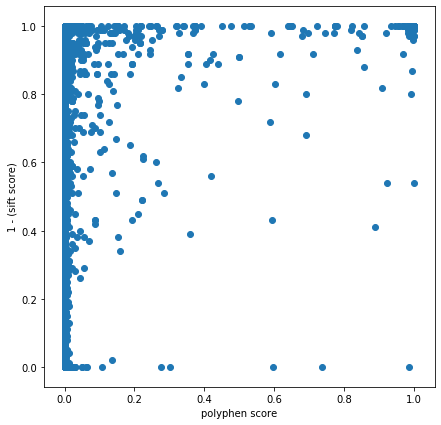

array([[1.        , 0.34901659],
       [0.34901659, 1.        ]])

In [448]:
from matplotlib import pyplot as plt
import numpy as np
plt.scatter(final_df['polyphen_score'], 1- final_df['sift_score'])
plt.xlabel('polyphen score')
plt.ylabel('1 - (sift score)')
plt.show()

np.corrcoef(final_df['polyphen_score'].dropna(), 1 - final_df['sift_score'].dropna())

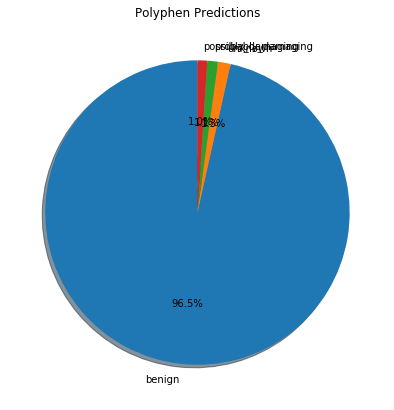

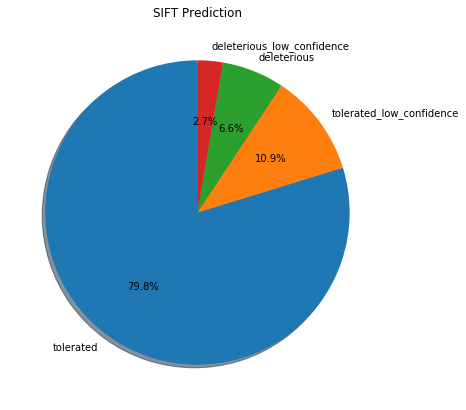

In [437]:
import matplotlib

final_df['polyphen_prediction'].value_counts().plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.ylabel('')
plt.title('Polyphen Predictions')

plt.show()
plt.title('SIFT Prediction')
final_df['sift_prediction'].value_counts().plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.ylabel('')
plt.show()

In [491]:
final_df['polyphen_prediction'].value_counts()
final_df['sift_prediction'].value_counts()

tolerated                     3330
tolerated_low_confidence       457
deleterious                    276
deleterious_low_confidence     112
Name: sift_prediction, dtype: int64

### Integrate ClinVar

In [487]:
con = pymysql.connect(host='127.0.0.1', unix_socket='/opt/lampp/var/mysql/mysql.sock', 
                      user='root', passwd='', db='current_project')

clinvar_data = pd.read_sql("SELECT clinical_significance, rs_number " +
                          " FROM clinvar ", con)

final_df_with_clinvar = pd.merge(final_df, clinvar_data, how='left', left_on='rsNumber', right_on='rs_number')
final_df_with_clinvar.drop("rs_number", axis=1)
final_df_with_clinvar = final_df_with_clinvar.drop_duplicates()
final_df_with_clinvar['clinical_significance'].value_counts()


Benign                                                 447
Benign/Likely benign                                   113
Likely benign                                           59
Uncertain significance                                  48
Conflicting interpretations of pathogenicity            28
no interpretation for the single variant                 9
risk factor                                              8
not provided                                             7
drug response                                            6
Pathogenic                                               5
association                                              3
other                                                    2
Conflicting interpretations of pathogenicity, other      2
Affects, association                                     1
Name: clinical_significance, dtype: int64

In [555]:
#final_df[(final_df["freq"] > 0) & (final_df["freq"] < 0.1000)].shape
ranges = pd.cut(final_df['freq'], [0,0.1000,0.2000,0.3000,0.4000,0.5000,0.6000,0.7000,0.8000,0.9000,1.0000])
final_df_freq_range=final_df.groupby(ranges)['freq'].agg('count')


[2207, 294, 227, 224, 238, 255, 213, 256, 270, 711]

In [553]:
ranges2 = pd.cut(gnomad_data['freq'], [0,0.1000,0.2000,0.3000,0.4000,0.5000,0.6000,0.7000,0.8000,0.9000,1.0000])
gnomad_freq_range = gnomad_data.groupby(ranges2)['freq'].agg('count')
gnomad_freq_range.tolist()

[1044434, 8000, 4859, 3281, 2883, 2055, 1539, 1412, 1224, 2302]

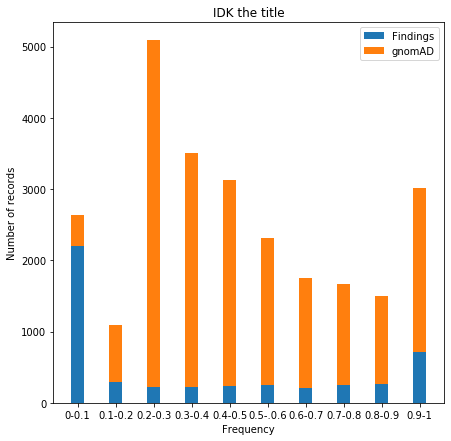

In [585]:
import numpy as np
import matplotlib.pyplot as plt
import math

N = 10
finding_number = (2207, 294, 227, 224, 238, 255, 213, 256, 270, 711)
gnomAD_number = (434, 800, 4859, 3281, 2883, 2055, 1539, 1412, 1224, 2302)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, finding_number, width)
p2 = plt.bar(ind, gnomAD_number, width, bottom=finding_number)

plt.ylabel('Number of records')
plt.xlabel('Frequency')
plt.title('IDK the title')
plt.xticks(ind, ('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-.0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1'))
#plt.yticks(np.arange(0, 1046641, 100))
plt.legend((p1[0], p2[0]), ('Findings', 'gnomAD'))

plt.show()